In [4]:
import json
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['STHeiti', 'SimHei', 'Microsoft YaHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

base_path = Path('回测') / 'res'

strategy_files = {
    '等权配置': 'equal_weights.json',
    '动态权重(有状态)': 'dynamic_weights.json',
    '动态权重(无状态)': 'dynamic_weights_without_regime.json',
    '规则配置': 'rule_based.json',
}

strategy_data = {}
for name, fname in strategy_files.items():
    fpath = base_path / fname
    if not fpath.exists():
        raise FileNotFoundError(f'未找到回测结果文件: {fpath}')
    with open(fpath, 'r', encoding='utf-8') as f:
        strategy_data[name] = json.load(f)

print('已成功读取策略回测结果:', list(strategy_data.keys()))

已成功读取策略回测结果: ['等权配置', '动态权重(有状态)', '动态权重(无状态)', '规则配置']


In [5]:
# 构建四个策略的核心绩效指标对比表（第5组 = 高因子组合）

metrics = [
    '整体@平均收益(%)',
    '整体@标准差(%)',
    '整体@夏普比率',
    '整体@胜率(%)',
    '整体@最大回撤%(日线)',
]

summary_rows = []
for name, data in strategy_data.items():
    df_ret = pd.DataFrame(data['收益率检验'])
    row5 = df_ret[df_ret['组名'] == '第5组'].iloc[0]

    # 最终累计收益率（取“累计收益率”中第5组与基准的最后一个值）
    df_cum = pd.DataFrame(data['累计收益率'])
    final_port = df_cum['第5组'].iloc[-1]
    final_bench = df_cum['基准'].iloc[-1]

    summary = {
        '策略': name,
        '最终累计收益(第5组, %)': final_port,
        '基准最终累计收益(%)': final_bench,
    }
    for m in metrics:
        summary[m] = row5[m]
    summary_rows.append(summary)

summary_df = pd.DataFrame(summary_rows).set_index('策略')
summary_df.round(2)

,"最终累计收益(第5组, %)",基准最终累计收益(%),整体@平均收益(%),整体@标准差(%),整体@夏普比率,整体@胜率(%),整体@最大回撤%(日线)
策略,,,,,,,
等权配置,17.42,10.03,1.97,6.26,0.32,55.56,-13.96
动态权重(有状态),29.77,10.03,3.28,9.04,0.36,66.67,-16.91
动态权重(无状态),32.46,10.03,3.45,8.14,0.42,77.78,-11.99
规则配置,18.93,10.03,2.36,9.99,0.24,55.56,-21.54


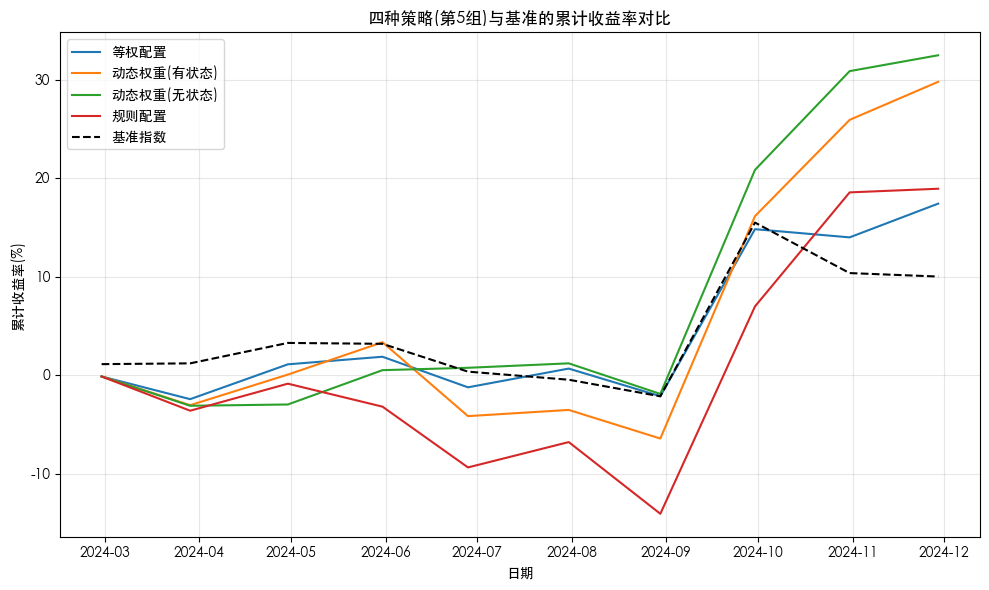

In [6]:
# 四个策略与基准的累计收益率对比曲线（第5组组合）

cum_series = {}
benchmark = None

for name, data in strategy_data.items():
    df_cum = pd.DataFrame(data['累计收益率']).copy()
    df_cum['截止日'] = pd.to_datetime(df_cum['截止日'])
    df_cum.set_index('截止日', inplace=True)

    # 记录策略本身（第5组）
    cum_series[name] = df_cum['第5组']

    # 记录一次基准曲线
    if benchmark is None:
        benchmark = df_cum['基准']

cum_all = pd.concat(cum_series, axis=1)

plt.figure(figsize=(10, 6))
for col in cum_all.columns:
    plt.plot(cum_all.index, cum_all[col], label=col)

plt.plot(benchmark.index, benchmark.values, label='基准指数', linestyle='--', color='black')
plt.xlabel('日期')
plt.ylabel('累计收益率(%)')
plt.title('四种策略(第5组)与基准的累计收益率对比')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

(截止日
 2024-02-29    0.0115
 2024-03-29    0.0007
 2024-04-30    0.0204
 2024-05-31   -0.0008
 2024-06-28   -0.0273
 Name: 基准, dtype: float64,
 {'等权配置': 截止日
  2024-02-29   -0.0010
  2024-03-29   -0.0231
  2024-04-30    0.0362
  2024-05-31    0.0076
  2024-06-28   -0.0305
  Name: 第5组, dtype: float64,
  '动态权重(有状态)': 截止日
  2024-02-29   -0.0010
  2024-03-29   -0.0292
  2024-04-30    0.0320
  2024-05-31    0.0328
  2024-06-28   -0.0725
  Name: 第5组, dtype: float64,
  '动态权重(无状态)': 截止日
  2024-02-29   -0.0010
  2024-03-29   -0.0298
  2024-04-30    0.0014
  2024-05-31    0.0358
  2024-06-28    0.0024
  Name: 第5组, dtype: float64,
  '规则配置': 截止日
  2024-02-29   -0.0010
  2024-03-29   -0.0348
  2024-04-30    0.0285
  2024-05-31   -0.0235
  2024-06-28   -0.0637
  Name: 第5组, dtype: float64})

/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_8011/2697567406.py:69: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pd.DataFrame(risk_metrics).T[['CAGR', 'Vol', 'Sharpe', 'Sortino', 'MaxDD', 'DD_Duration_Months', 'WinRate', 'Calmar']].applymap(lambda x: round(x, 4) if isinstance(x, (int, float, np.floating)) else x)


,CAGR,Vol,Sharpe,Sortino,MaxDD,DD_Duration_Months,WinRate,Calmar
等权配置,0.2124,0.2056,1.0294,4.6733,-0.0393,3.0,0.5,5.4106
动态权重(有状态),0.3671,0.2977,1.1856,3.4556,-0.0945,3.0,0.6,3.8853
动态权重(无状态),0.4009,0.2687,1.3806,6.3496,-0.0306,2.0,0.7,13.1028
规则配置,0.2313,0.3275,0.7754,2.3725,-0.1393,6.0,0.5,1.6603


/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_8011/707394721.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pd.DataFrame(relative_metrics).T.applymap(lambda x: round(x, 4) if isinstance(x, (int, float, np.floating)) else x)


,Ann_Excess_Return,Tracking_Error,Information_Ratio,CAPM_Alpha_Annual,CAPM_Beta,Corr_with_Bench
等权配置,0.0909,0.0733,1.0552,0.0910,0.8984,0.9403
动态权重(有状态),0.2455,0.1743,1.2547,0.2014,1.1287,0.8161
动态权重(无状态),0.2794,0.1600,1.4792,0.2363,1.0029,0.8034
规则配置,0.1098,0.2154,0.5554,0.0986,1.1568,0.7602


/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_8011/3456618257.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ]].applymap(lambda x: round(x, 4) if isinstance(x, (int, float, np.floating)) else x)
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_8011/3456618257.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ic_df = pd.DataFrame(ic_stats).T.applymap(lambda x: round(x, 4) if isinstance(x, (int, float, np.floating)) else x)
/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_8011/3456618257.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  disc_df = pd.DataFrame(discrimination_stats).T.applymap(lambda x: round(x, 4) if isinstance(x, (int, float, np.floating)) else x)


(             CAGR     Vol  Sharpe   MaxDD  WinRate
 等权配置       0.0074  0.0964  0.1195 -0.0445      0.4
 动态权重(有状态) -0.2450  0.1678 -1.5749 -0.2403      0.3
 动态权重(无状态) -0.2655  0.2161 -1.3010 -0.2506      0.5
 规则配置      -0.0715  0.2393 -0.1966 -0.2295      0.4,
            IC_Mean  IC_Std  IC_IR_Annual
 等权配置       -0.0300  0.1416       -0.7339
 动态权重(有状态)  -0.0878  0.1892       -1.6072
 动态权重(无状态)  -0.0833  0.2575       -1.1209
 规则配置        0.0167  0.2819        0.2048,
            T_Stat  P_Value
 等权配置         0.11    54.18
 动态权重(有状态)   -1.45     9.29
 动态权重(无状态)   -1.19    13.38
 规则配置        -0.18    43.13)

/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_8011/1519177830.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  turnover_df = pd.DataFrame(turnover_stats).T.applymap(lambda x: round(x, 4) if isinstance(x, (int, float, np.floating)) else x)


,Avg_Turnover_pct,Avg_Monthly_Return_pct,Unit_Return_per_Turnover
等权配置,51.1111,1.764,0.0345
动态权重(有状态),24.4444,2.941,0.1203
动态权重(无状态),42.2222,3.091,0.0732
规则配置,32.2222,2.116,0.0657


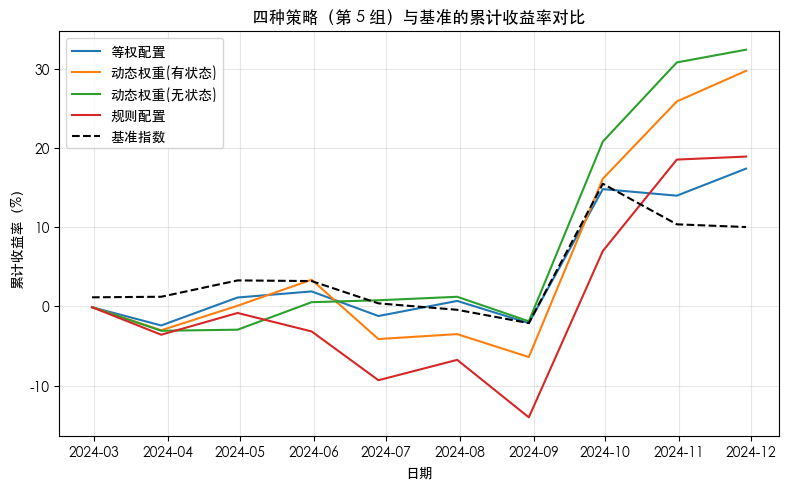

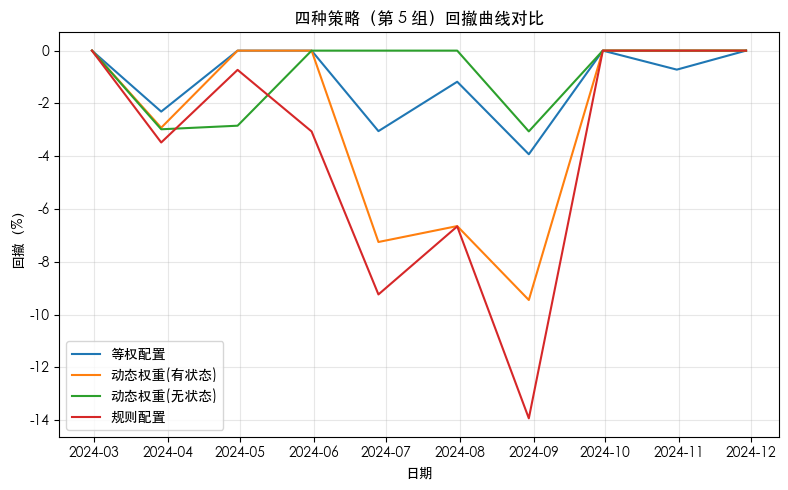

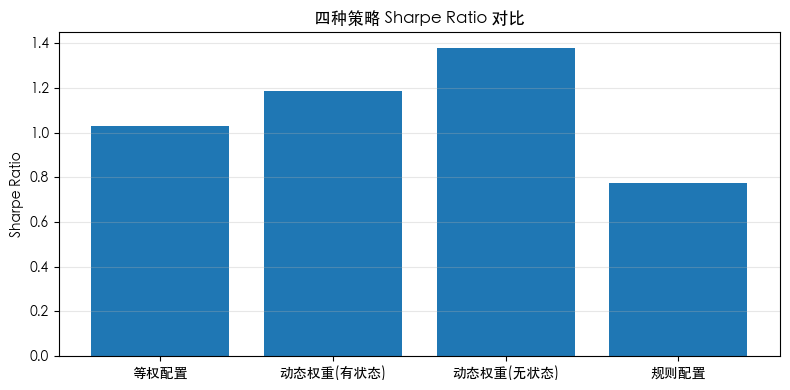

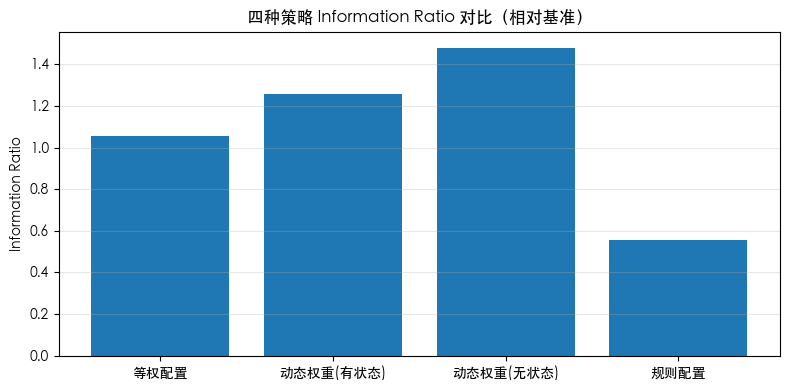

/var/folders/49/t84jntk56wn101s6026p72cc0000gn/T/ipykernel_8011/2206816587.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_display = summary_sorted.applymap(


,CAGR,Vol,Sharpe,MaxDD,Calmar,Information_Ratio,Avg_Turnover_pct
动态权重(无状态),0.4009,0.2687,1.3806,-0.0306,13.1028,1.4792,42.2222
动态权重(有状态),0.3671,0.2977,1.1856,-0.0945,3.8853,1.2547,24.4444
规则配置,0.2313,0.3275,0.7754,-0.1393,1.6603,0.5554,32.2222
等权配置,0.2124,0.2056,1.0294,-0.0393,5.4106,1.0552,51.1111


在样本期内，动态权重策略整体的年化收益率约为 38.40%，高于静态（等权与规则）策略的约 22.19%；同时动态权重的平均 Sharpe 为 1.28，亦高于静态策略的 0.90，提示动态权重在本样本内提供了更优的风险调整后收益。

在两类动态权重策略之间，引入 Regime 的版本年化收益率为 36.71%，不含 Regime 版本为 40.09%；对应 Sharpe 分别为 1.19 与 1.38，信息比率分别为 1.25 与 1.48。从该样本结果看，Regime 信息对收益与风险调整后收益的边际贡献为 有限或不稳定。

从综合指标看，年化收益最高的策略为“动态权重(无状态)”，其 Sharpe 为 1.38，年化波动约为 26.87%，最大回撤约为 -3.06%。与其他策略相比，其更高收益同时伴随 Sharpe 的提升而非单纯依赖更高波动，说明收益提升更多体现为风险调整后的改进而非纯粹加杠杆式的风险放大（结论仍受样本长度与市场环境限制）。


In [15]:
!jupyter nbconvert --to webpdf --allow-chromium-download "analysis_all.ipynb"

[NbConvertApp] Converting notebook analysis_all.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1456346 bytes to analysis_all.pdf
